# Deep Learning Pneumonia Detection

**Authors:** Meir Alelov, Greg Burgess

![UNICEF pneumonia mortality rates](images/UNICEF_mortality_percentages.png)

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Worldwide, over 800,000 children under five die every year from pneumonia. Pediatric mortality rates are especially high in regions affected by poverty and inadequate access to health care.  [source](https://data.unicef.org/topic/child-health/pneumonia/)

Low-resource settings are less likely to have access to rapid radiological interpretation of images, which could result in a delay of clinical care and poorer prognosis [source](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

We set out to determine whether we could use deep learning to quickly and accurately classify pneumonia in x-ray images. Information from a fast, automated deep learning classifier could assist clinicians in low-resource settings to make pneumonia diagnoses more quickly. Expediting diagnoses in these situations may result in a substantial reduction in childhood mortality from pneumonia.

## Data Understanding

Data for this investigation were originally acquired by [Kermany et al. (2018)](https://doi.org/10.1016/j.cell.2018.02.010). 

These chest X-ray images were acquired at Guangzhou Women and Children’s Medical Center in Guangzhou, China as part of routine clinical care. Patients were aged between one and five years old. 
- Pneumonia is indicated by abnormal opacification in the image
- X-rays were labelled as pneumonia vs. normal by trained two expert radiologists. To avoid grading errors, the evaluation set was checked by a third expert.

![example images](images/training_images_orig.jpg)


Kermany et al. provided public access to their data in [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2). We are using an organized subset of their data, which was downloaded from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).



Directory structure
```
├── chest-xray                    
│   ├── test                      <- Test set images
│   │   ├── Normal                     <- Normal lung photos        (234 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (390 images)
│   │   │   └── ...
│   ├── train                     <- Training set images
│   │   ├── Normal                     <- Normal lung photos        (1341 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (3875 images)
│   │   │   └── ...
│   ├── val                       <- Training set images
│   │   ├── Normal                     <- Normal lung photos        (8 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (8 images)
│   │   │   └── ...
```

In [1]:
# Import Relevant Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# scikit-learn
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay, plot_roc_curve, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Neural network libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.layers import Dense, Dropout, Flatten

np.random.seed(42)
%matplotlib inline

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Data Preparation

- Downloaded data from Kaggle and unzipped into data directory
- We chose not to use the images in the `val` directory, because that data only had 8 normal and 8 pneumonia images. Because of that, we intend to create our own validation set with a larger number of images.
- Used ImageDataGenerator module in tensorflow to genreate batches of vectorized image data
- Because we dropped the val directory, we created a new validation set using the validation_split option 
- Set uniform image size of 128x128
- We later use ImageDataGenerator to augment our training data set, by manipulating the original training images to provide additional training images after various manipulation techniques (shear, scale, shift, etc.). This was done in an attempt to make *poorer* quality training data so that the model would generalize to unseen data better.

We can set up paths to run these models in different environments. Below is an example mounting a Google Drive in Google Colab.

In [2]:
# Running on local machine
root_path = './'

# # Running in Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/'

In [3]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

The ImageDataGenerator class can generate batches of vectorized image data that is suitable for input into keras models. 

Importantly, the ImageDataGenerator can use the directory structure to determine the target categories (i.e., normal vs. pneumonia) for use during training and evaluation of the models.

In [4]:
# Instantiate ImageDataGenerator, and create 'validation' subset containing 20% of data
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)

# train_set comes from `train_path`, but contains only training subset (first 80% of images)
train_set = idg.flow_from_directory(train_path, 
                                    target_size=(128, 128), 
                                    color_mode='grayscale', 
                                    class_mode='binary', 
                                    subset='training')

# validation_set comes from `train_path`, but contains only validation subset (last 20% of images)
validation_set = idg.flow_from_directory(train_path, 
                                         target_size=(128, 128), 
                                         color_mode='grayscale', 
                                         class_mode='binary', 
                                         subset='validation')

# test_set comes from `test_path`, and contains images that were completely unseen by model during training
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We rescaled the original images to 128x128 size using `idg` above. This will reduce the size of the image data going into the models. This makes it less computationally expensive, but will maintain enough image detail for the model to utilize during training.

Let's look at examples after this rescaling.

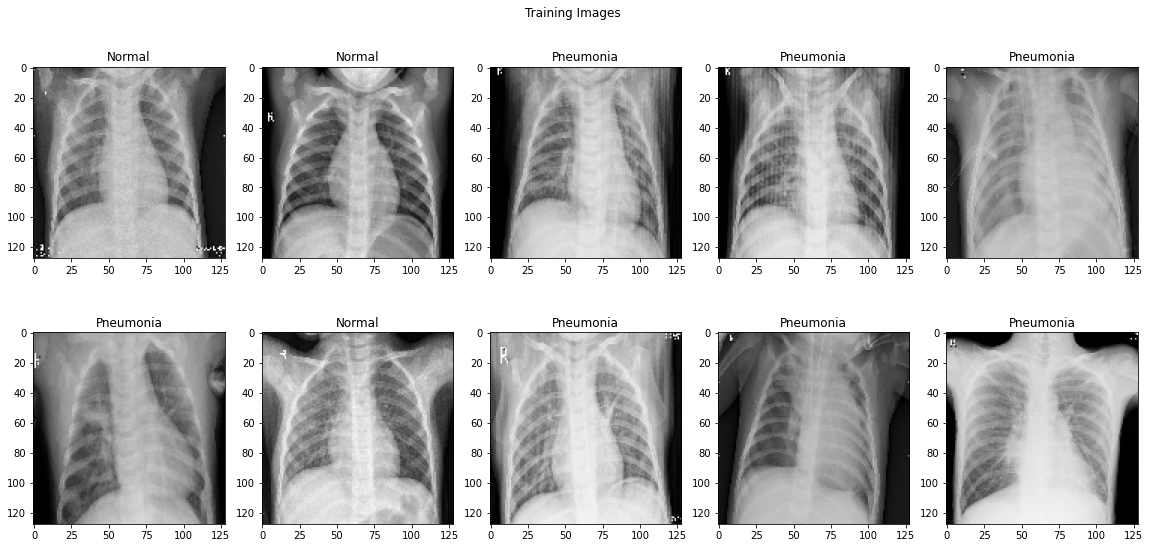

In [5]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_images = train_set.next()


# Visualize
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    # Load image into numpy array and re-scale (back to 0 through 255)
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5] # make a 2x5 grid, and step through it
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
#plt.savefig('../images/training_images_orig.jpg', transparent = False, bbox_inches="tight")

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### DummyClassifier

In [6]:
# Get information about image size and number of images
# to be used in running DummyClassifier() below

train_target_size = train_set.image_shape[0:2] # image dimensions (128x128)
train_batch_size  = train_set.n                # number of images in train set

test_target_size  = test_set.image_shape[0:2]  # image dimensions (128x128)
test_batch_size   = test_set.n                 # number of images in test set

In [7]:
# Batch size set to the total number of images found above, so that dummy model gets full data set. 
# Validation set not needed for dummy model
train_set_dummy = idg.flow_from_directory(train_path,
                                          target_size=train_target_size,
                                          color_mode='grayscale', 
                                          class_mode='binary', 
                                          subset='training', 
                                          batch_size=train_batch_size)

test_set_dummy  = idg.flow_from_directory(test_path, 
                                          target_size=test_target_size,
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          shuffle=False,
                                          batch_size=test_batch_size)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Split train and test dummy sets into images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

In [9]:
baseline_model = DummyClassifier(strategy= 'most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

Baseline accuracy: 0.625
Baseline recall: 1.0
Baseline recall: 0.625


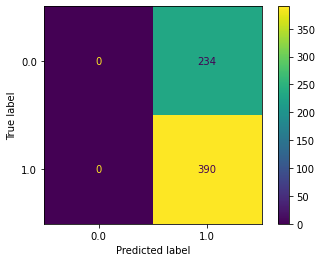

In [10]:
# Get predicted values from dummy model (always predict "most_frequent" class)
y_base_pred = baseline_model.predict(test_images)

base_acc = baseline_model.score(test_images, test_labels)
base_recall = recall_score(test_labels, y_base_pred)
base_precision = precision_score(test_labels, y_base_pred)

print(f"Baseline accuracy: {base_acc}")
print(f"Baseline recall: {base_recall}")
print(f"Baseline recall: {base_precision}")


plot_confusion_matrix(baseline_model, test_images, test_labels);

### First simple model

We created this function to plot training performance for our neural network models

In [22]:
def model_metrics(results):
    
#    results = model.history
    
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    train_recall = results.history['recall']
    train_precision = results.history['precision']
    
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    val_recall = results.history['val_recall']
    val_precision = results.history['val_precision']
    
    print(f"AUC score (train final epoch): {results.history['auc'][-1]:.3f}")
    print(f"AUC score (val final epoch)  : {results.history['val_auc'][-1]:.3f}")

    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()


    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    
    sns.lineplot(x=results.epoch, y=train_recall, ax=ax3, label='train_recall')
    sns.lineplot(x=results.epoch, y=val_recall, ax=ax3, label='val_recall')
    ax3.set_title('Recall')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Recall')
    ax3.legend()


    sns.lineplot(x=results.epoch, y=train_precision, ax=ax4, label='train_precision')
    sns.lineplot(x=results.epoch, y=val_precision, ax=ax4, label='val_precision')
    ax4.set_title('Precision')    
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend()

In [ ]:
def conf_and_rocauc(model):
    
    #confusion matrix
    
    y_pred = model.predict(test_set)
    y_hat = (y_pred > 0.5)           
    display(ConfusionMatrixDisplay(
        confusion_matrix(test_set.classes, y_hat), 
        display_labels=['Normal', 'Pneumonia']).plot());
    
    
    #ROC_AUC
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure()
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

Here we created our model

In [12]:
fsm = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

fsm.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 
             'TruePositives', 'TrueNegatives',
             'FalsePositives', 'FalseNegatives', 
             'AUC']
)

fsm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                524320    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 524,353
Trainable params: 524,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
fsm_results = fsm.fit(train_set,
                      epochs=20,
                      batch_size=None, 
                      verbose=1, 
                      validation_data=validation_set)

Epoch 1/20
131/131 [==============================] - 75s 571ms/step - loss: 0.5062 - accuracy: 0.7553 - recall: 0.9894 - precision: 0.7564 - true_positives: 3067.0000 - true_negatives: 85.0000 - false_positives: 988.0000 - false_negatives: 33.0000 - auc: 0.7851 - val_loss: 0.4265 - val_accuracy: 0.8188 - val_recall: 0.9948 - val_precision: 0.8065 - val_true_positives: 771.0000 - val_true_negatives: 83.0000 - val_false_positives: 185.0000 - val_false_negatives: 4.0000 - val_auc: 0.9355
Epoch 2/20
131/131 [==============================] - 74s 562ms/step - loss: 0.3714 - accuracy: 0.8567 - recall: 0.9894 - precision: 0.8444 - true_positives: 3067.0000 - true_negatives: 508.0000 - false_positives: 565.0000 - false_negatives: 33.0000 - auc: 0.9459 - val_loss: 0.3476 - val_accuracy: 0.8821 - val_recall: 0.9716 - val_precision: 0.8817 - val_true_positives: 753.0000 - val_true_negatives: 167.0000 - val_false_positives: 101.0000 - val_false_negatives: 22.0000 - val_auc: 0.9431
Epoch 3/20
131/

Epoch 18/20
131/131 [==============================] - 66s 505ms/step - loss: 0.1292 - accuracy: 0.9518 - recall: 0.9710 - precision: 0.9644 - true_positives: 3010.0000 - true_negatives: 962.0000 - false_positives: 111.0000 - false_negatives: 90.0000 - auc: 0.9878 - val_loss: 0.1631 - val_accuracy: 0.9291 - val_recall: 0.9381 - val_precision: 0.9655 - val_true_positives: 727.0000 - val_true_negatives: 242.0000 - val_false_positives: 26.0000 - val_false_negatives: 48.0000 - val_auc: 0.9822
Epoch 19/20
131/131 [==============================] - 61s 466ms/step - loss: 0.1265 - accuracy: 0.9535 - recall: 0.9713 - precision: 0.9663 - true_positives: 3011.0000 - true_negatives: 968.0000 - false_positives: 105.0000 - false_negatives: 89.0000 - auc: 0.9887 - val_loss: 0.1554 - val_accuracy: 0.9358 - val_recall: 0.9523 - val_precision: 0.9609 - val_true_positives: 738.0000 - val_true_negatives: 238.0000 - val_false_positives: 30.0000 - val_false_negatives: 37.0000 - val_auc: 0.9828
Epoch 20/20


AUC score (train final epoch): 0.989
AUC score (val final epoch)  : 0.984


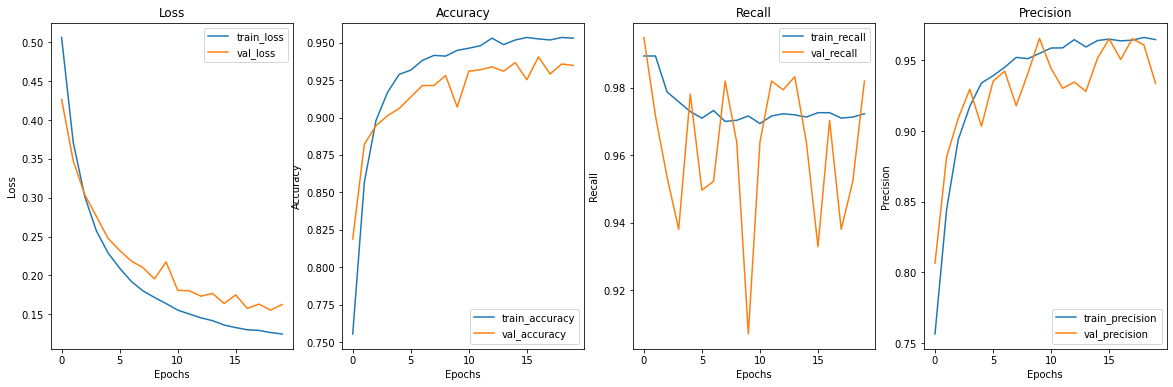

In [23]:
model_metrics(fsm_results)

In [ ]:
conf_and_rocauc(fsm)

#### Wow!!!

Train and validation scores are both very high, suggesting that we may already have a highly accurate model! 

Before we choose to proceed with this model, we need to evaluate against the unseen test set.

We expect similarly high scores in the unseen test set as well!

In [15]:
fsm.evaluate(test_set)

20/20 [==============================] - 4s 210ms/step - loss: 0.7799 - accuracy: 0.7179 - recall: 0.9872 - precision: 0.6924 - true_positives: 385.0000 - true_negatives: 63.0000 - false_positives: 171.0000 - false_negatives: 5.0000 - auc: 0.9066


[0.7799389362335205,
 0.7179487347602844,
 0.9871794581413269,
 0.6924460530281067,
 385.0,
 63.0,
 171.0,
 5.0,
 0.9065855741500854]

#### Oh no!

Unfortunately, model performance suffered on the unseen data. Our accuracy and precision are far worse on the test set than the validation set, even though *both* of those data sets were unseen during training!

This is a confusing situation. This discrepancy between performance on the test and validations set could indicate one of two things:
1. Perhaps the validation split was "lucky". Maybe, simply by chance, the ImageDataGenerator chose a split of validation images that were unusually accurate during the model evaluation.
    - To check whether this might be true, we will use different validation sets by creating a cross-validation function. 
    - That function will use the withhold different segments of the training data as validation sets, to see whether the original validation set was just lucky by comparison.
    - If we get similar performance on different validation splits, it suggests that we're not getting this performance by chance.

2. Perhaps the images in the test set were more dissimilar from the train set than the validation images were. 
    - Stated differently, if images in the `test` directory were different (came from different x-ray machines or children of different ages) than images in the `train` directory, they would be less similar to the training data than our validation images were.
    - To evaluate this possibility, we used the image manipulation functions within ImageDataGenerator to augment the training set with degraded copies of the original data. This will make the training data more variable, so as to make training harder, resulting in a more "fit" model.


### Cross-validation

We used the KerasClassifier class to wrap our model into a container that can be used by scikit-learn's cross_val_score() method.

In [30]:
# we might need this to be in a function to wrap it for our custom crossval
def build_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(128, 128, 1)),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='SGD',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 
                            'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])
    return model

In [31]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=20,
                                          verbose=3)

Before passing the keras_model into the cross_val_score() method, we need to set up training images and labels in a form that cross_val_score can use. We created a new ImageDataGenerator that made one large batch containing all of the training data. But then we use next() to separate the batch into a np.ndarray that can be used by cross_vall_score to make our k-folds.

In [ ]:
idg_cv_comp = ImageDataGenerator(rescale=1/255)

train_set_cv_comp = idg_cv_comp.flow_from_directory(train_path, target_size=(128, 128),
                                    color_mode='grayscale', 
                                    class_mode='binary',
                                    batch_size=5216,
                                    subset='training')

In [32]:
train_images, train_labels = next(train_set_cv_comp)
print(len(train_images), len(train_labels))

5216 5216


In [33]:
cv_scores = cross_val_score(keras_model, train_images, train_labels, cv=5, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.959, total=  14.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.942, total=  13.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.954, total=  12.9s
[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.940, total=  10.3s
[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] ..................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [ ]:
print(cv_scores)
print(np.mean(cv_scores))

In [46]:
fsm_results.history['val_accuracy'][-1]

0.9348034262657166

### Data Augmentation

In [47]:
train_idg = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.20,
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                                   

train_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')

# We don't augment the data in the test set, so we can use the same test_set variable from above

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_images_aug = train_set_aug.next()


# Visualize
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    # Load image into numpy array and re-scale (back to 0 through 255)
    img = np.array(train_images_aug[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5] # make a 2x5 grid, and step through it
    ax.set_title(class_dict[train_images_aug[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()

In [48]:
fsm_aug = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

fsm_aug.compile(optimizer='SGD',
                loss='binary_crossentropy',
                metrics=['accuracy', 'Recall', 'Precision', 
                         'TruePositives', 'TrueNegatives', 
                         'FalsePositives', 'FalseNegatives', 
                         'AUC']
               )

In [ ]:
fsm_aug_results = fsm_aug.fit(
                        train_set_aug,
                        epochs=200,
                        batch_size=None,
                        verbose=1, 
                        validation_data=validation_set_aug)

Epoch 1/200
131/131 [==============================] - 88s 675ms/step - loss: 0.5701 - accuracy: 0.7405 - recall: 0.9932 - precision: 0.7435 - true_positives: 3079.0000 - true_negatives: 11.0000 - false_positives: 1062.0000 - false_negatives: 21.0000 - auc: 0.5442 - val_loss: 0.5597 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6596
Epoch 2/200
131/131 [==============================] - 95s 729ms/step - loss: 0.5576 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.6004 - val_loss: 0.5426 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0

Epoch 18/200
131/131 [==============================] - 91s 694ms/step - loss: 0.4922 - accuracy: 0.7740 - recall: 0.9765 - precision: 0.7768 - true_positives: 3027.0000 - true_negatives: 203.0000 - false_positives: 870.0000 - false_negatives: 73.0000 - auc: 0.7540 - val_loss: 0.5120 - val_accuracy: 0.7843 - val_recall: 0.9123 - val_precision: 0.8183 - val_true_positives: 707.0000 - val_true_negatives: 111.0000 - val_false_positives: 157.0000 - val_false_negatives: 68.0000 - val_auc: 0.7637
Epoch 19/200
131/131 [==============================] - 82s 629ms/step - loss: 0.4983 - accuracy: 0.7664 - recall: 0.9674 - precision: 0.7743 - true_positives: 2999.0000 - true_negatives: 199.0000 - false_positives: 874.0000 - false_negatives: 101.0000 - auc: 0.7447 - val_loss: 0.4958 - val_accuracy: 0.7776 - val_recall: 0.9561 - val_precision: 0.7891 - val_true_positives: 741.0000 - val_true_negatives: 70.0000 - val_false_positives: 198.0000 - val_false_negatives: 34.0000 - val_auc: 0.7561
Epoch 20

131/131 [==============================] - 88s 669ms/step - loss: 0.4662 - accuracy: 0.7891 - recall: 0.9594 - precision: 0.7977 - true_positives: 2974.0000 - true_negatives: 319.0000 - false_positives: 754.0000 - false_negatives: 126.0000 - auc: 0.7887 - val_loss: 0.4765 - val_accuracy: 0.7766 - val_recall: 0.9342 - val_precision: 0.7991 - val_true_positives: 724.0000 - val_true_negatives: 86.0000 - val_false_positives: 182.0000 - val_false_negatives: 51.0000 - val_auc: 0.7800
Epoch 35/200
131/131 [==============================] - 86s 657ms/step - loss: 0.4688 - accuracy: 0.7827 - recall: 0.9542 - precision: 0.7945 - true_positives: 2958.0000 - true_negatives: 308.0000 - false_positives: 765.0000 - false_negatives: 142.0000 - auc: 0.7838 - val_loss: 0.4676 - val_accuracy: 0.7776 - val_recall: 0.9626 - val_precision: 0.7861 - val_true_positives: 746.0000 - val_true_negatives: 65.0000 - val_false_positives: 203.0000 - val_false_negatives: 29.0000 - val_auc: 0.7902
Epoch 36/200
131/131 

In [ ]:
model_metrics(fsm_aug_results)

In [ ]:
conf_and_rocauc(fsm_aug)

### multilayer model

After deducing that augmented data provides more robust model training, we chose to add complexity to the model. We will train on augmented data from here forward.

Adding additional hidden layers can result in overfitting. Therefore, we added L2 regularization to our hidden layers, and switched the activation function of the hidden layers [from sigmoid to relu](https://machinelearningmastery.com/activation-regularization-for-reducing-generalization-error-in-deep-learning-neural-networks/). 

In [ ]:
multilayer_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

multilayer_model.compile(optimizer='SGD',
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'Recall', 'Precision', 
                                  'TruePositives', 'TrueNegatives', 
                                  'FalsePositives', 'FalseNegatives', 
                                  'AUC'])

In [ ]:
multilayer_model.summary()

In [ ]:
multilayer_model_results = multilayer_model.fit(train_set_aug, 
                                                epochs=200,
                                                batch_size=None, 
                                                verbose=1, 
                                                validation_data=validation_set_aug)

In [ ]:
model_metrics(multilayer_model_results)

In [ ]:
conf_and_rocauc(multilayer_model)

### CNN

In [ ]:
deep_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

deep_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'Recall', 'Precision', 
                          'TruePositives', 'TrueNegatives', 
                          'FalsePositives', 'FalseNegatives', 
                          'AUC'])

deep_cnn.summary()

In [ ]:
deep_cnn_results = deep_cnn.fit(train_set_aug, 
                                epochs=200, 
                                batch_size=None, 
                                validation_data=validation_set_aug)

In [ ]:
model_metrics(deep_cnn_results)

In [ ]:
conf_and_rocauc(deep_cnn)

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Evaluation
- Why precision and recall?
    - accuracy can be misleading for imbalanced data sets
    - recall: of all positive cases, what proportion does the model classify as true positives. This is frequently called sensitivity in the medical literature.
    - In this medical context, it is important to avoid classifying x-rays of children
    - While recall is important, we don't want avoid maximizing recall by classify children without pneumonia as having pneumonia. In these low-resource regions, providing unnecessary treatment to healthy children will 

In [ ]:
deep_cnn_test = deep_cnn.evaluate(test_set)

In [ ]:
##cnn5_loss, cnn5_acc, cnn5_recall, cnn5_prc = cnn5_model.evaluate(test_set)
deep_cnn_acc = deep_cnn_test[1]
deep_cnn_recall = deep_cnn_test[2]
deep_cnn_precision = deep_cnn_test[3]

In [ ]:
fig, ax = plt.subplots()

sns.barplot(base_acc, deep_cnn_acc)
sns.barplot(base_recall, deep_cnn_recall)
sns.barplot(base_precision, deep_cnn_precision)

ax1.set_title('Score Comparison')
ax1.set_xticklabels(['Baseline', 'Final Model'])
ax1.set_ylabel('Scores')
ax1.legend(['Accuracy', 'Recall', 'Precision'])
plt.savefig('images/model_comparisons.jpg', transparent = False, bbox_inches="tight");

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***